# NSRT

In [1]:
import h5py
import torch
import random
import matplotlib.pyplot as plt

from model.data import HDF5Dataset, get_train_loaders
from model.step import warp_frame, compute_motion_mask, tonemap

In [2]:
def display_hdr(image, axis, title, gamma=2.2):
    ldr = tonemap(image, gamma=gamma)
    ldr = torch.clamp(ldr, 0, 1)
    axis.imshow(ldr)
    axis.set_title(title)
    axis.axis('off')

def display_mask(mask, axis, title):
    axis.imshow(mask, cmap='gray')
    axis.axis('off')
    axis.set_title(title)

## Dataset and Dataloader

In [3]:
dataset_file = "datasets/bistro.hdf5"
chunk_size = 8

train_dataset = HDF5Dataset(
    file=dataset_file,
    native_resolution='225p',
    target_resolution='900p',
    motion_threshold=1.0,
    patch_size=80,
    chunk_size=chunk_size,
    spatial_stride=60,
    temporal_stride=4,
    train=True,
)

test_dataset = HDF5Dataset(
    file=dataset_file,
    native_resolution='225p',
    target_resolution='900p',
    motion_threshold=1.0,
    patch_size=80,
    chunk_size=chunk_size,
    spatial_stride=60,
    temporal_stride=4,
    train=False,
)

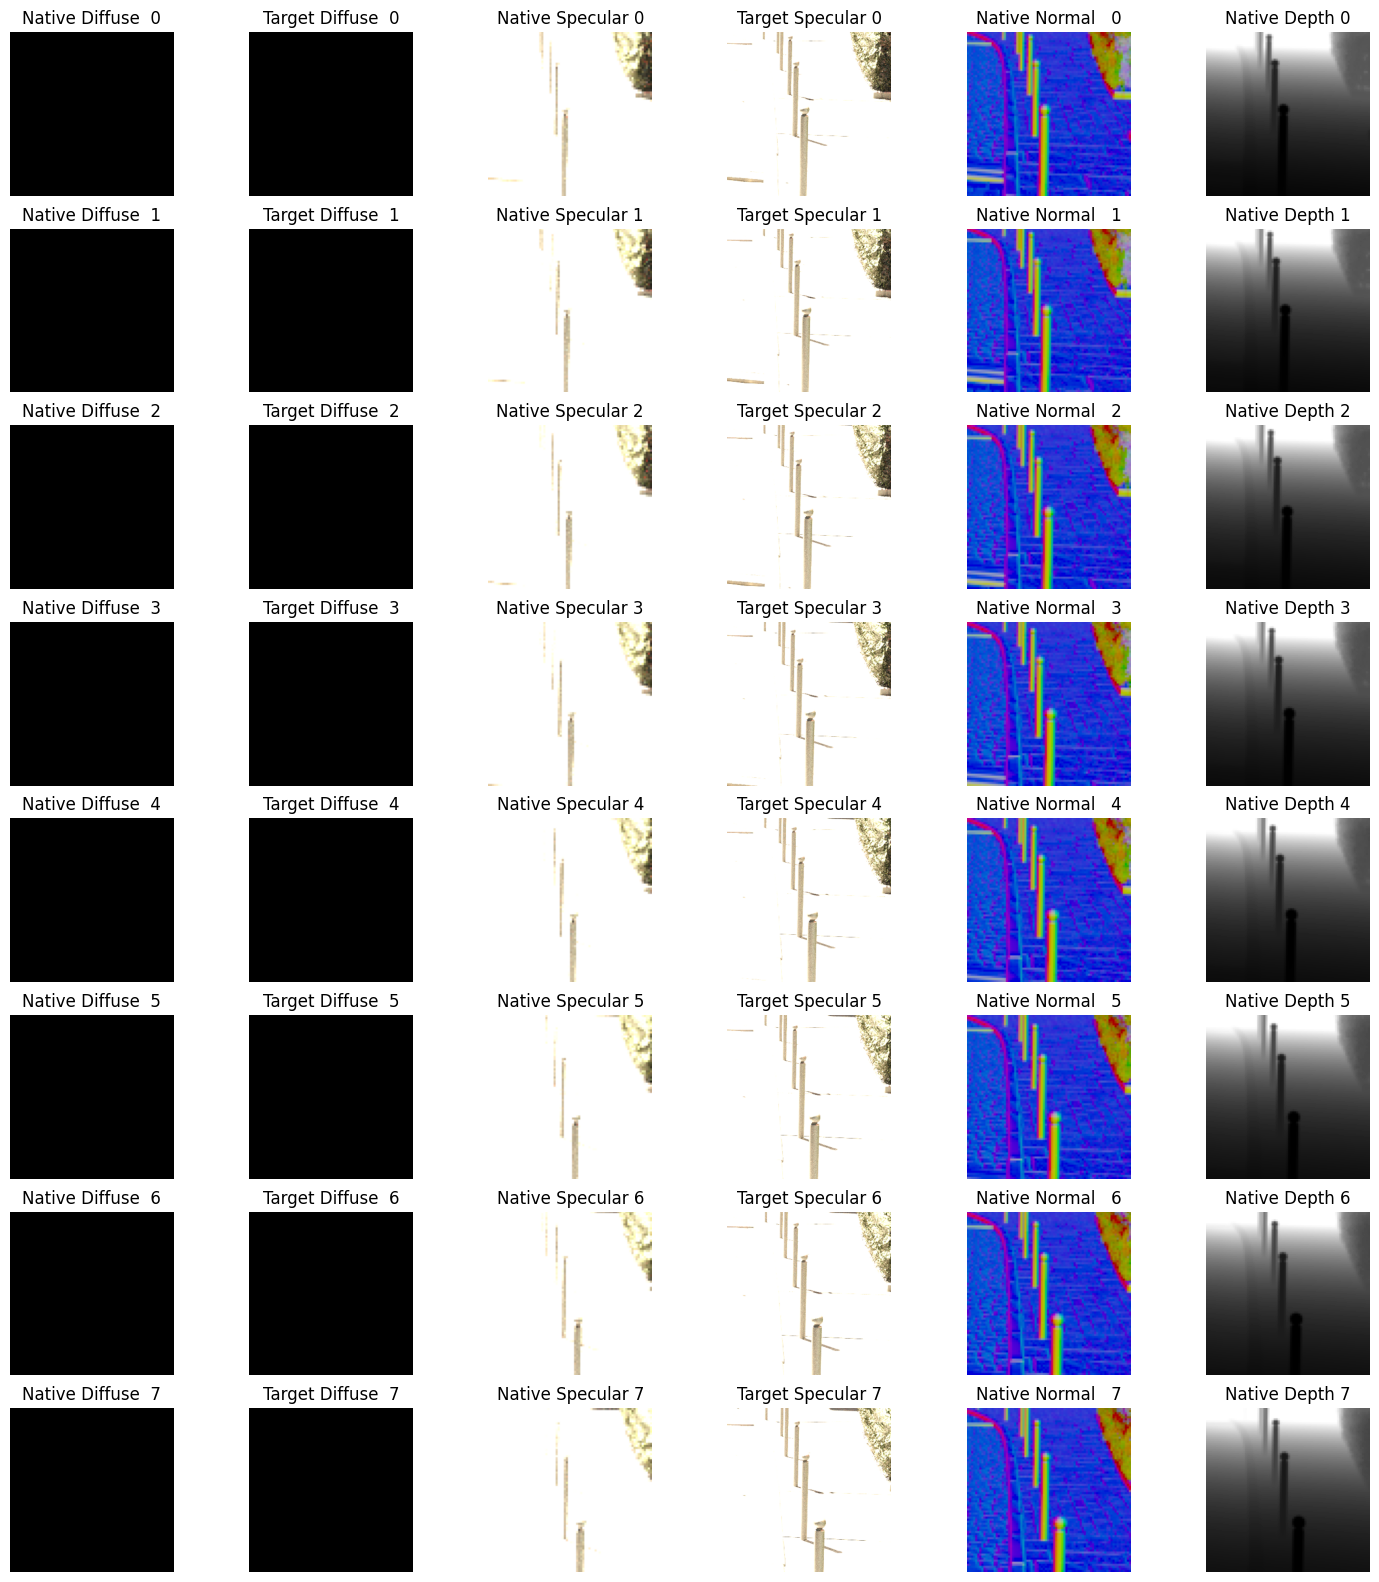

In [4]:
idx = random.randrange(0, len(train_dataset))
x, y = train_dataset[idx]

fig, axes = plt.subplots(chunk_size, 6, figsize=(18, 20))

# Display all frames in chunk
for i in range(8):
    # Frames are (C, H, W) tensors, where C = dataset.channels_per_frame
    display_hdr(x[i,  :3, ...].permute(1, 2, 0), axes[i, 0], f"Native Diffuse  {i}")
    display_hdr(y[i,  :3, ...].permute(1, 2, 0), axes[i, 1], f"Target Diffuse  {i}")
    display_hdr(x[i, 3:6, ...].permute(1, 2, 0), axes[i, 2], f"Native Specular {i}")
    display_hdr(y[i, 3:6, ...].permute(1, 2, 0), axes[i, 3], f"Target Specular {i}")
    display_hdr(x[i, 6:9, ...].permute(1, 2, 0), axes[i, 4], f"Native Normal   {i}")
    display_mask(x[i, 9, ...], axes[i, 5], f"Native Depth {i}")

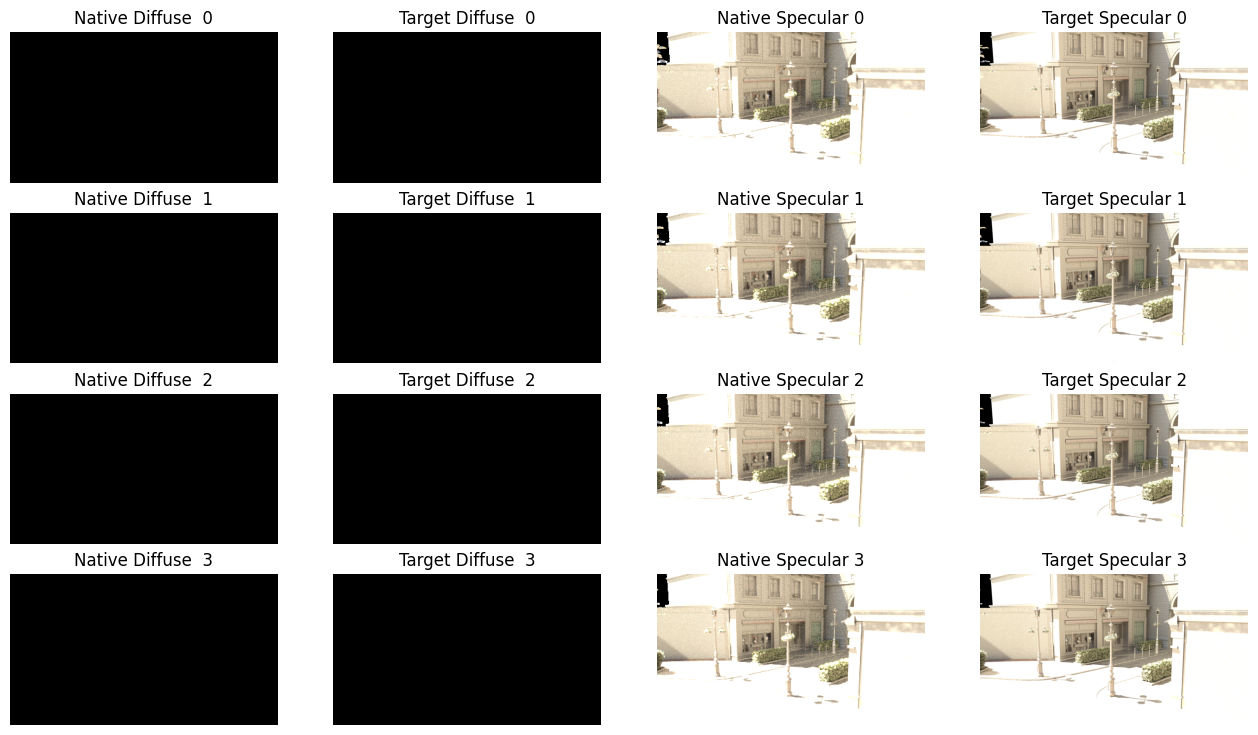

In [5]:
idx = random.randrange(0, len(test_dataset))
x, y = test_dataset[idx]

fig, axes = plt.subplots(4, 4, figsize=(16, 9))

for i in range(4):
    # Frames are (C, H, W) tensors, where C = dataset.channels_per_frame
    display_hdr(x[i,  :3, ...].permute(1, 2, 0), axes[i, 0], f"Native Diffuse  {i}")
    display_hdr(y[i,  :3, ...].permute(1, 2, 0), axes[i, 1], f"Target Diffuse  {i}")
    display_hdr(x[i, 3:6, ...].permute(1, 2, 0), axes[i, 2], f"Native Specular {i}")
    display_hdr(y[i, 3:6, ...].permute(1, 2, 0), axes[i, 3], f"Target Specular {i}")

In [6]:
batch_size = 8
train_dataloader, _ = get_train_loaders(train_dataset, n_workers=8, batch_size=batch_size)
train_dataloader = iter(train_dataloader)

In [14]:
x, y = next(train_dataloader)
print(x.shape, y.shape)
print(x.dtype, y.dtype)

torch.Size([8, 8, 14, 80, 80]) torch.Size([8, 8, 8, 320, 320])
torch.float32 torch.float32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.66343296..2.0608172].


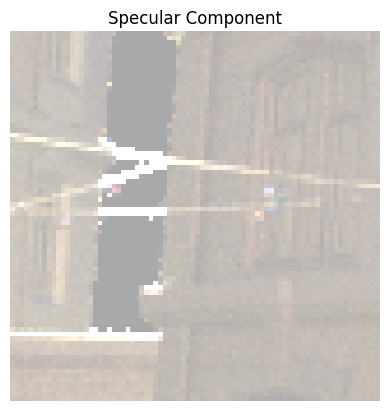

In [20]:
plt.axis('off')
plt.title("Specular Component")
_ = plt.imshow(tonemap((x[0, 0, 3:6, ...].permute(1, 2, 0) + 1) / 2))

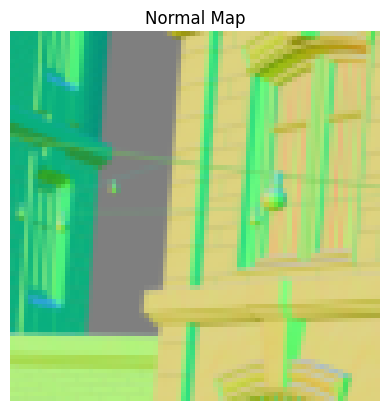

In [19]:
plt.axis('off')
plt.title("Normal Map")
_ = plt.imshow((x[0, 0, 6:9, ...].permute(1, 2, 0) + 1) / 2)

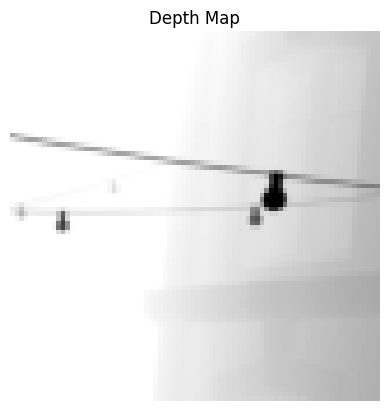

In [18]:
plt.axis('off')
plt.title("Depth Map")
_ = plt.imshow(x[0, 0, 9:10, ...].permute(1, 2, 0), cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4212952..2.4637623].


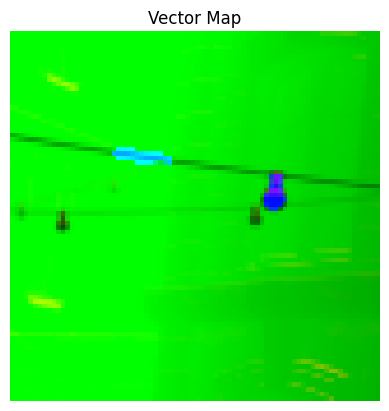

In [17]:
plt.axis('off')
plt.title("Vector Map")
_ = plt.imshow(x[0, 0, 8:11, ...].permute(1, 2, 0))

## Motion mask threshold tunning

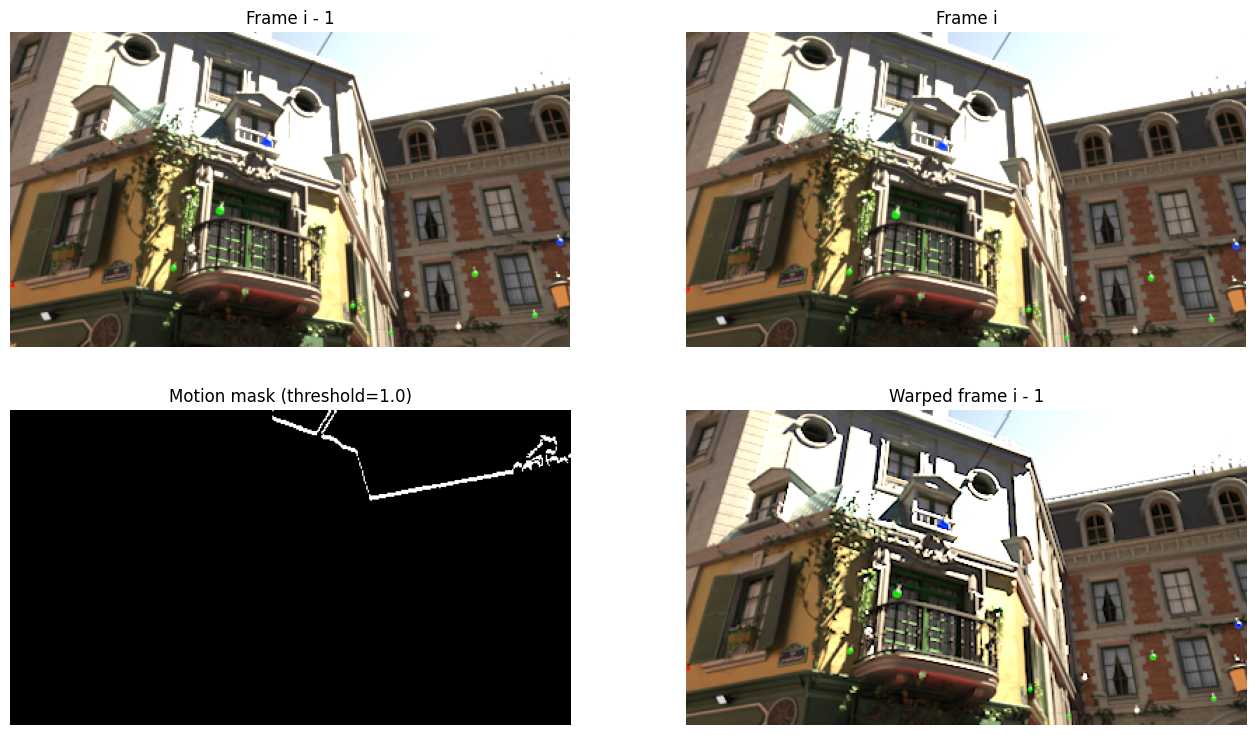

In [8]:
dataset = "datasets/bistro.hdf5"

seq   = random.randrange(0, 16)
frame = random.randrange(1, 100)

with h5py.File(dataset, 'r') as f:
    # Motion masks are computed on native resolution
    curr = torch.tensor(f[f'225p/train/seq-{seq:03d}/frame-{frame:03d}/combined'][:3, ...])
    prev = torch.tensor(f[f'225p/train/seq-{seq:03d}/frame-{frame-1:03d}/combined'][:3, ...])
    curr2prev = torch.tensor(f[f'225p/train/seq-{seq:03d}/frame-{frame:03d}/vector'][:2, ...])
    prev2curr = torch.tensor(f[f'225p/train/seq-{seq:03d}/frame-{frame-1:03d}/vector'][2:, ...])

# Fix coordinate system and directions, depending on the nature of dataset
# The current dataset defines the vectors relative to the origin in the top-left corner and the y-axis pointing upwards
curr2prev[1, ...] = -curr2prev[1, ...]
prev2curr[1, ...] = -prev2curr[1, ...]
# The 2 last channels of the vector layer represent motions from next frame to previous frame, but we need the opposite
prev2curr = -prev2curr

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 9))

# Frames are (C, H, W) tensors
display_hdr(prev.permute(1, 2, 0), ax1, 'Frame i - 1')
display_hdr(curr.permute(1, 2, 0), ax2, 'Frame i')

# Warp frame i - 1 to frame i, using motion vectors at frame i
# The function operate on batches, so we need to add a batch dimension
warp = warp_frame(prev[None, ...], curr2prev[None, ...], curr[None, ...])
warp = warp.squeeze(0)  # get rid of the batch dimension
display_hdr(warp.permute(1, 2, 0), ax4, 'Warped frame i - 1')

# Tune the threshold to get a good mask
threshold = 1.0
mask = compute_motion_mask(curr2prev[None, ...], prev2curr[None, ...], threshold=threshold)
mask = mask.squeeze(0)  # get rid of the batch dimension
display_mask(mask.permute(1, 2, 0), ax3, f'Motion mask (threshold={threshold})')

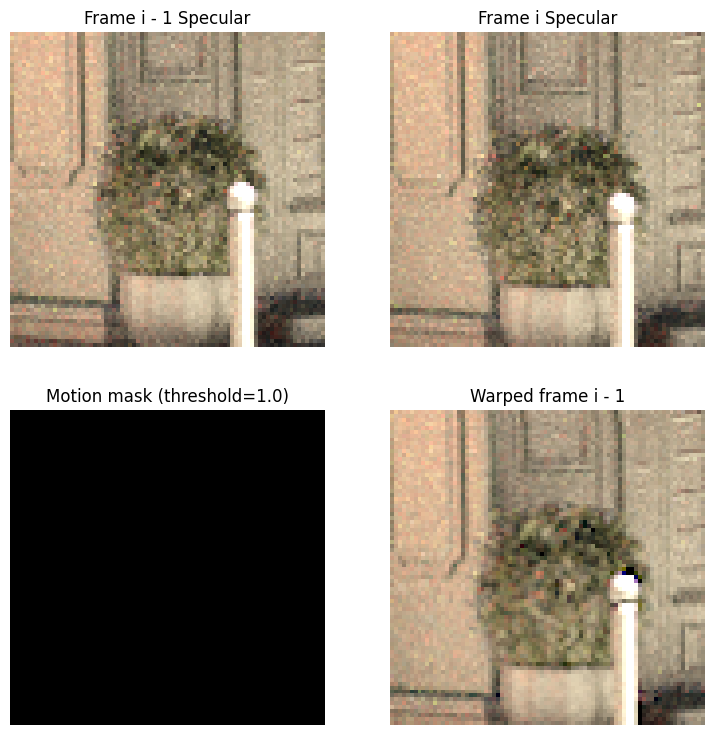

In [9]:
x, _ = next(train_dataloader)

chunk = random.randrange(0, batch_size)
frame = random.randrange(1, chunk_size)

prev = x[:, frame - 1, ...]
curr = x[:, frame,     ...]
curr2prev = x[:, frame,     -4:-2, ...]
prev2curr = x[:, frame - 1, -2:,   ...]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 9))

display_hdr(prev[chunk, 3:6].permute(1, 2, 0), ax1, 'Frame i - 1 Specular')
display_hdr(curr[chunk, 3:6].permute(1, 2, 0), ax2, 'Frame i Specular')

warp = warp_frame(prev, curr2prev, curr)
display_hdr(warp[chunk, 3:6].permute(1, 2, 0), ax4, 'Warped frame i - 1')

mask = compute_motion_mask(curr2prev, prev2curr, threshold)
display_mask(mask[chunk].permute(1, 2, 0), ax3, f'Motion mask (threshold={threshold})')